# Argosim tutorial - Part 4

In this tutorial we will explore the `clean` module. This module implements the Hogbom Clean algorithm.

In [1]:
from argosim.antenna_utils import *
from argosim.imaging_utils import *
from argosim.metrics_utils import *
from argosim.plot_utils import *
from argosim.data_utils import *

import numpy as np
import matplotlib.pyplot as plt

Take a look at the loaded modules and check the functions available in the modules we haven't explored yet.

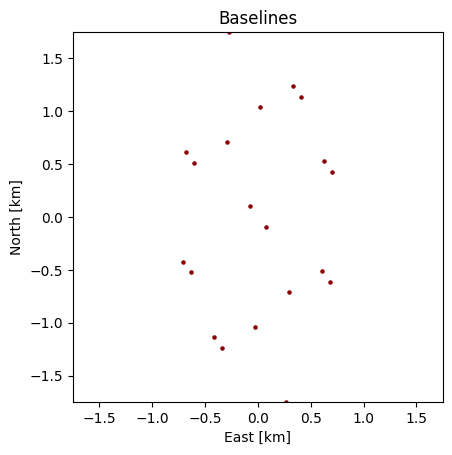

In [ ]:
# Create an antenna array with 5 antennas randomly distributed in a 1x2 km area.
array = random_antenna_arr(n_antenna=5, E_lim=1e3, N_lim=2e3)

# Compute the baselines
baselines = get_baselines(array)

# Plot the baselines.
plot_baselines(baselines, ENU=True)


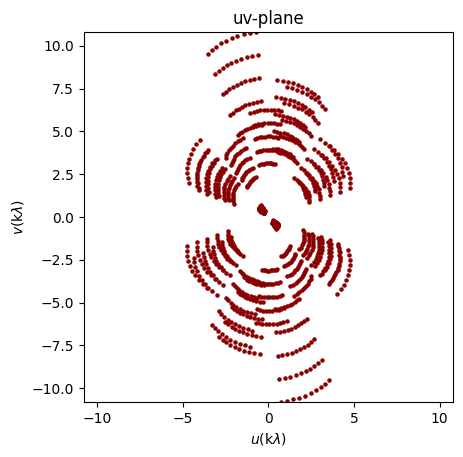

In [8]:
# Compute the uv-sampling tracks for the following parameters:
# Latitude = 20 degrees
lat = 20 * np.pi / 180  # Convert degrees to radians
# Declination = 45 degrees
dec = 45 * np.pi / 180  # Convert degrees to radians
# Track time = 3 hours
track_time = 3
# Start time = -1 hours
t_0 = -1
# Number of time samples = 10
n_times = 10
# Frequency = 1.5 GHz
f = 1.5e9  # Frequency in Hz
# Bandwidth = 1 GHz
df = 1e9  # Bandwidth in Hz
# Number of frequency channels = 5
n_freqs = 5
track, _  = uv_track_multiband(
    b_ENU=baselines,
    lat=lat,
    dec=dec,
    track_time=track_time,
    t_0= t_0,
    n_times= n_times,
    f= f,
    df=df,
    n_freqs=n_freqs
)

# Plot the baselines and the uv-tracks using the plot_utils module.
plot_baselines(track)


### Simulate the sky model
We will start by simulating a sky model. We will use the `data_utils` module from argosim. 

Check the function `n_source_sky` from the `data_utils` module. 

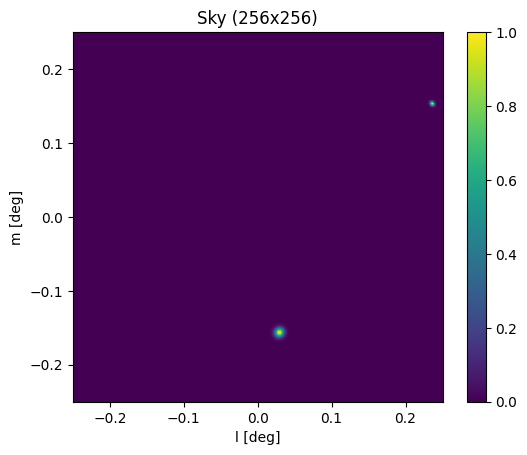

In [48]:
# Create the sky model using argosim.data_utils.n_source_sky()
im_size = (256,256)
fov = .5 # degrees
fov_size = (fov, fov)
sky_model = n_source_sky(im_size, fov, [0.01, 0.005], [1., 1.], norm="max")

# Plot the sky model
plot_sky(sky_model, fov_size=(fov, fov))


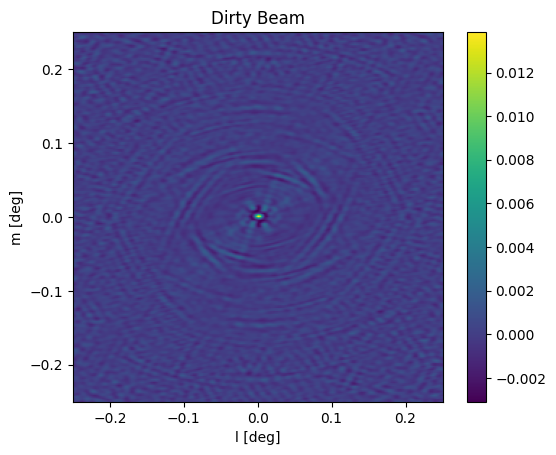

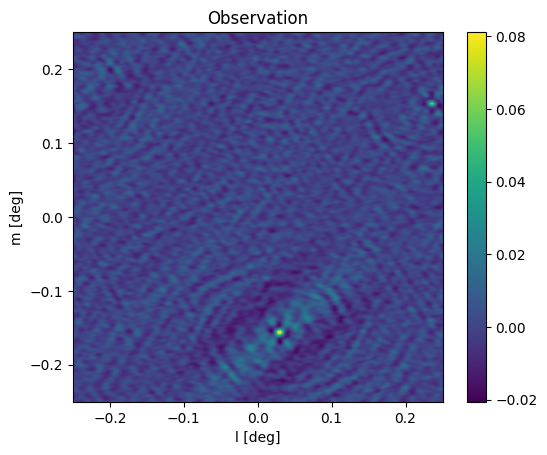

In [49]:
# Get the dirty image 
obs, dirty_beam = simulate_dirty_observation(sky_model, track, fov, sigma=0.02)

# Plot the dirty image and the beam
plot_sky(dirty_beam, fov_size=(fov, fov), title='Dirty Beam')
plot_sky(obs, fov_size=(fov, fov), title='Observation')

### Cleaning the observation

We will use the `clean` module to clean the observation. Check the function `hogbom_clean` from the `clean` module.

In [34]:
from argosim.clean import *

Reached threshold at iteration 95


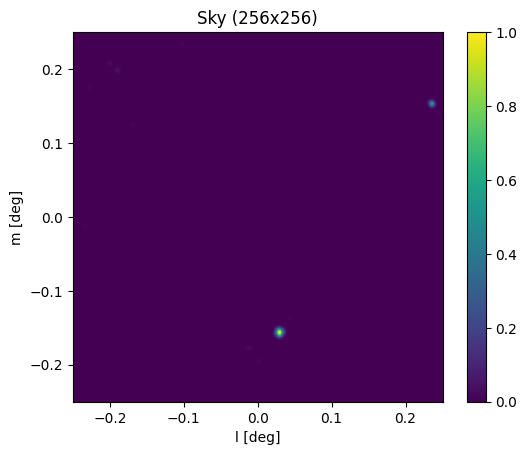

In [53]:
I_clean, _ = clean_hogbom(obs, dirty_beam, gamma=0.1, max_iter=100, threshold=1e-3 , clean_beam_size_px=3, res=False)
# normalize the clean image
I_clean /= np.max(I_clean)

# Plot the clean image
plot_sky(I_clean, fov_size)

### Metrics

We will use the `metrics` module to evaluate the cleaning. Check the function `compute_metrics` from the `metrics` module.

In [54]:
from argosim.metrics_utils import *

dict_keys(['mse', 'rel_mse', 'residual', 'ssim'])
MSE:  1.910998e-05
RMSE:  0.067240596
SSIM:  0.9970537745347023


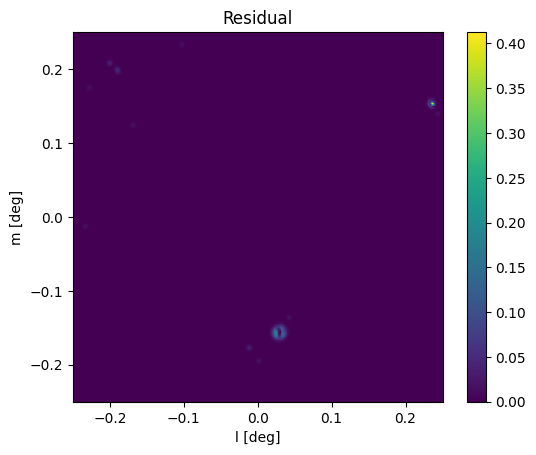

In [55]:
# compute the metrics
metrics = compute_metrics(sky_model, I_clean)
print(metrics.keys())
print("MSE: ", metrics['mse'])
print("RMSE: ", metrics['rel_mse'])
print("SSIM: ", metrics['ssim'])

# Plot the residual and check the mse
plot_sky(metrics['residual'], fov_size, title='Residual')

# Verify that the mse is the mean of the squared residuals
